<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   

# CUSTOM Multiple Task for Part Classification using HOOPS AI


In [1]:
import hoops_ai
import os

hoops_ai.set_license(os.getenv("HOOPS_AI_LICENSE"), validate= False)

In [2]:
# 
from cad_tasks_custom_part_classification import get_flow_name
flow_name = get_flow_name()
print(f"Flow name: {flow_name}")

Schema loaded from: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\manufacturing_schema.json
Flow name: ETL_Multi_Y_Part_Classification


## Schema Management

The schema defines the label structure for classification tasks. It can be:
- Built programmatically in code
- Loaded from an exported JSON file

Set `LOAD_SCHEMA_FROM_FILE = True` in [cad_tasks_custom_part_classification.py](cad_tasks_custom_part_classification.py) to load from file.


In [3]:
# Verify schema export location
from cad_tasks_custom_part_classification import SCHEMA_FILE_PATH, LOAD_SCHEMA_FROM_FILE
import os

print(f"Schema mode: {'Loading from file' if LOAD_SCHEMA_FROM_FILE else 'Building in code'}")
print(f"Schema file path: {SCHEMA_FILE_PATH}")
print(f"Schema file exists: {os.path.exists(SCHEMA_FILE_PATH)}")

if os.path.exists(SCHEMA_FILE_PATH):
    import json
    with open(SCHEMA_FILE_PATH, 'r') as f:
        schema_preview = json.load(f)
    print(f"\nSchema preview (first 3 keys): {list(schema_preview.keys())[:3]}")

Schema mode: Loading from file
Schema file path: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\manufacturing_schema.json
Schema file exists: True

Schema preview (first 3 keys): ['version', 'domain', 'groups']


In [4]:
import os
import pathlib
from typing import Tuple, List

# Import the flow builder framework from the library
import hoops_ai
from hoops_ai.flowmanager import flowtask


from hoops_ai.cadaccess import HOOPSLoader, HOOPSTools
from hoops_ai.cadencoder import BrepEncoder
from hoops_ai.dataset import DatasetExplorer
from hoops_ai.storage import DataStorage, CADFileRetriever, LocalStorageProvider
from hoops_ai.storage.datasetstorage.schema_builder import SchemaBuilder

## Configuring Setup

In [5]:
# Configuration - Using simpler paths
nb_dir = pathlib.Path.cwd()
flows_outputdir = nb_dir.joinpath("out")
# Import task functions from external module for ProcessPoolExecutor compatibility
from cad_tasks_custom_part_classification import gather_fabwave_files, encode_data_for_ml_training, custom_graph_classification, get_flow_name

## ETL Data Pipeline

Configure the data sources for the ETL pipeline. This example uses the FabWave CAD dataset.


In [6]:
# data source
datasources_dir = [str(nb_dir.parent.joinpath("packages","cadfiles","fabwave"))
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD_1_15_Classes", "Bolts")),
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD_1_15_Classes", "Bushing_Damping_Liners")),
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD25-45_TOTAL1000", "Sleeve Washers"))   
                  ]

## Pipeline Execution

This cell runs the ETL pipeline to generate ML inputs after encoding the data.

**Configuration:** Set `SKIP_ETL = False` to run the full pipeline, or `SKIP_ETL = True` to load existing data.


In [7]:
# Configuration: Skip ETL Pipeline
SKIP_ETL = False  # Set to True to skip ETL and load existing data

# Path to existing flow file (only used if SKIP_ETL = True)
EXISTING_FLOW_FILE = str(nb_dir.joinpath("out", "flows", flow_name, f"{flow_name}.flow"))

if SKIP_ETL:
    print("⏭️  Skipping ETL Pipeline - Loading existing dataset")
    print(f"Flow file: {EXISTING_FLOW_FILE}")
    if not os.path.exists(EXISTING_FLOW_FILE):
        print(f"⚠️  WARNING: Flow file not found at {EXISTING_FLOW_FILE}")
        print("Set SKIP_ETL = False to run the ETL pipeline")
    else:
        flow_file = EXISTING_FLOW_FILE
        print("✅ Flow file loaded successfully")
else:
    print("🔄 ETL Pipeline will run in the next cell")

🔄 ETL Pipeline will run in the next cell


In [8]:
# ETL Pipeline - Only runs if SKIP_ETL = False
if not SKIP_ETL:
    # Create and run the Data Flow
    flow_name = get_flow_name()
    cad_flow = hoops_ai.create_flow(
        name=flow_name,
        tasks=[gather_fabwave_files, encode_data_for_ml_training],
        max_workers=20,
        flows_outputdir=str(flows_outputdir),
        ml_task="Part Classification",
        auto_dataset_export=True,  # Enable automatic dataset merging
        export_visualization=False  # Disable visualization export
    )

    # Run the flow to process all files
    print("Starting flow execution with parallel processing...")
    flow_output, output_dict, flow_file = cad_flow.process(inputs={'cad_datasources': datasources_dir})

    print(f"  Flow file: {flow_file}")
    print(f"\nTotal processing time: {output_dict.get('Duration [seconds]', {}).get('total', 0):.2f} seconds")
    print(f"Files processed: {output_dict.get('file_count', 0)}")
else:
    print("✅ Skipped ETL Pipeline - Using existing flow file")
    print(f"Flow file: {flow_file}")

Starting flow execution with parallel processing...
|INFO| FLOW | ######### Flow 'ETL_Multi_Y_Part_Classification' start #######
|WARNING| FLOW | Cleaning up existing flow directory: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification
|WARNING| FLOW | Removing all previous outputs for flow 'ETL_Multi_Y_Part_Classification' to avoid build conflicts.
|INFO| FLOW | Flow directory successfully cleaned and recreated: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification
|INFO| FLOW | 
Flow Execution Summary
|INFO| FLOW | ==================================================
|INFO| FLOW | Task 1: gather fabwave files
|INFO| FLOW |     Inputs : cad_datasources
|INFO| FLOW |     Outputs: cad_dataset
|INFO| FLOW | Task 2: Preparing data for Exploring and ML training
|INFO| FLOW |     Inputs : cad_dataset
|INFO| FLOW |     Outputs: cad_files_encoded
|INFO| FLOW |

DATA INGESTION:   0%|                                                                            | 0/1 [00:00<…

|INFO| FLOW | Executing ParallelTask 'Preparing data for Exploring and ML training' with 200 items.


DATA TRANSFORMATION:   0%|                                                                     | 0/200 [00:00<…

|WARNING| FLOW | Total number of items with errors: 3 (1.50%)
|WARNING| FLOW | Corrupted items are listed in 'C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\error_summary.json'.
|INFO| FLOW | Executing SequentialTask 'AutoDatasetExportTask'.
[DatasetMerger] Saved schema with 4 groups to metadata.json
|INFO| FLOW | Auto dataset export completed in 180.49 seconds
Sequential Task end=====================
|INFO| FLOW | Time taken: 423.66 seconds
|INFO| FLOW | ######### Flow 'ETL_Multi_Y_Part_Classification' end ######
  Flow file: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out/flows/ETL_Multi_Y_Part_Classification/ETL_Multi_Y_Part_Classification.flow

Total processing time: 423.66 seconds
Files processed: 200


## Data Serving : Analytics

In [9]:
explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:50801' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/197 [00:00<?, ?it/s]


--- Dataset Table of Contents ---

LABELS_GROUP:
  FILE_ID_CODE_LABELS_DATA: Shape: (197,), Dims: ('Labels_task_B_dim_0',), Size: 197
  TASK_A_DATA: Shape: (197,), Dims: ('Labels_task_B_dim_0',), Size: 197
  TASK_B_DATA: Shape: (197,), Dims: ('Labels_task_B_dim_0',), Size: 197
  TASK_C_DATA: Shape: (197,), Dims: ('Labels_task_B_dim_0',), Size: 197
  TASK_D_DATA: Shape: (197,), Dims: ('Labels_task_B_dim_0',), Size: 197

EDGES_GROUP:
  EDGE_CONVEXITIES_DATA: Shape: (25666,), Dims: ('edge',), Size: 25666
  EDGE_DIHEDRAL_ANGLES_DATA: Shape: (25666,), Dims: ('edge',), Size: 25666
  EDGE_INDICES_DATA: Shape: (25666,), Dims: ('edge',), Size: 25666
  EDGE_LENGTHS_DATA: Shape: (25666,), Dims: ('edge',), Size: 25666
  EDGE_TYPES_DATA: Shape: (25666,), Dims: ('edge',), Size: 25666
  EDGE_U_GRIDS_DATA: Shape: (25666, 10, 6), Dims: ('edge', 'u', 'component'), Size: 1539960
  FILE_ID_CODE_EDGES_DATA: Shape: (25666,), Dims: ('edge',), Size: 25666

FACES_GROUP:
  FACE_AREAS_DATA: Shape: (9353,), Dims

In [10]:
print(explorer.available_groups())

{'faces', 'graph', 'Labels', 'edges'}


In [11]:
print(explorer.available_arrays('Labels'))

{'task_D', 'task_A', 'task_B', 'file_id_code_Labels', 'task_C'}


In [12]:
# Visualization libraries
import matplotlib.pyplot as plt

def print_distribution_info(dist, title="Distribution"):
    """Helper function to print and visualize distribution data."""
    list_filecount = list()
    for i, bin_files in enumerate(dist['file_id_codes_in_bins']):
        list_filecount.append(bin_files.size)

    dist['file_count'] =list_filecount
    # Visualization with matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))
    
    bin_centers = 0.5 * (dist['bin_edges'][1:] + dist['bin_edges'][:-1])
    ax.bar(bin_centers, dist['file_count'], width=(dist['bin_edges'][1] - dist['bin_edges'][0]), 
           alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
    
    # Add file count annotations
    for i, count in enumerate(dist['file_count']):
        if count > 0:  # Only annotate non-empty bins
            ax.text(bin_centers[i], count + 0.5, f"{count}", 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f'{title} Histogram')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Material distribution created in 1.51 seconds



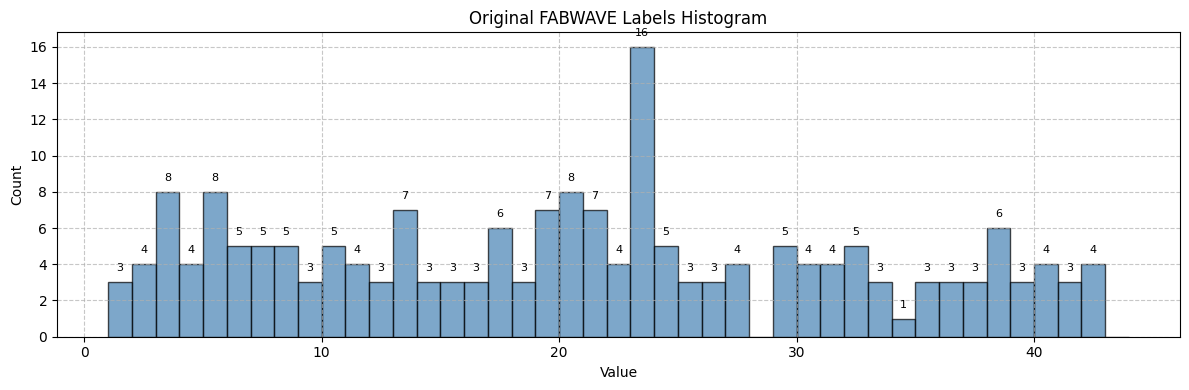

In [13]:
import time
start_time = time.time()
face_dist = explorer.create_distribution(key="task_A", bins=None, group="Labels")
print(f"Material distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(face_dist, title="Original FABWAVE Labels")

Material distribution created in 0.34 seconds



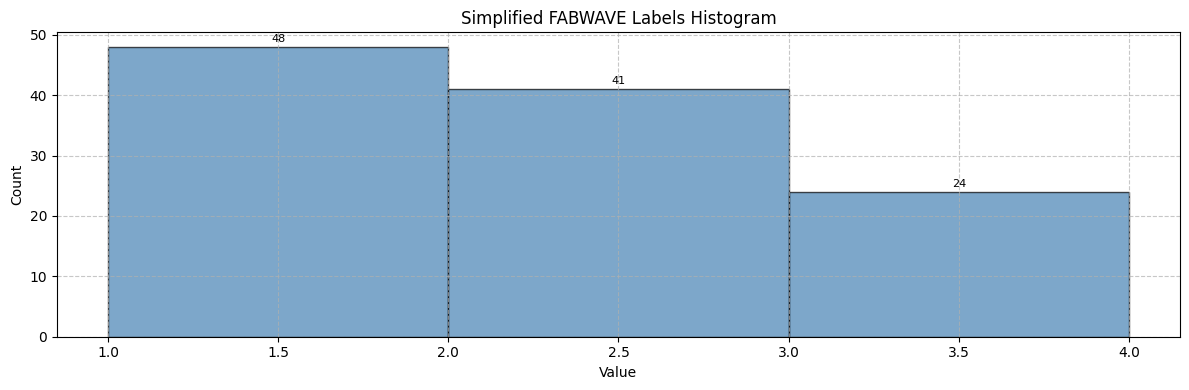

In [14]:
start_time = time.time()
face_dist = explorer.create_distribution(key="task_C", bins=None, group="Labels")
print(f"Material distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(face_dist, title="Simplified FABWAVE Labels")

# Machine Learning Training

## ML-Ready Dataset Preparation

The `DatasetLoader` prepares the merged dataset for machine learning training. It provides:

- **Stratified Splitting**: Creates train/validation/test splits while preserving class distributions
- **Subset Tracking**: Records file assignments in the dataset metadata


In [15]:
# Load and split dataset for machine learning
from hoops_ai.dataset import DatasetLoader

flow_path = pathlib.Path(flow_file)
loader = DatasetLoader(
    merged_store_path=str(flow_path.parent / f"{flow_path.stem}.dataset"),  
    parquet_file_path=str(flow_path.parent / f"{flow_path.stem}.infoset")
)

In [16]:
from hoops_ai.ml.EXPERIMENTAL import FlowTrainer


flow_root_dir = nb_dir.joinpath("out","flows", flow_name)

In [17]:
# Import custom graph classification model
import pathlib
import sys
notebooks_dir = pathlib.Path.cwd().parent
sys.path.insert(0, str(notebooks_dir.parent))
from custom_flow_model_graph_classification import CustomGraphClassification

## Import Custom Model

Import the custom graph classification model that will be used for training all tasks.


## Multi-Task Configuration

The encoding configuration defines four tasks:

**Task Configuration:**
- **task_A**: 45 classes (0-44) - Original part categories
- **task_B**: 45 classes (0-44) - Identical to task_A (for verification)
- **task_C**: 5 groups (0-4) - Simplified categories  
- **task_D**: 5 groups (0-4) - Identical to task_C (for verification)

This multi-task setup allows training different classification tasks on the same dataset.


## Training Results Analysis

### Expected Results:

**Identical Results Within Pairs:**
- **task_A ≈ task_B**: Training/test metrics should be nearly identical (same 45-class problem)
- **task_C ≈ task_D**: Training/test metrics should be nearly identical (same 5-group problem)

**Different Results Between Groups:**
- **task_A/B vs task_C/D**: Metrics will differ (45 classes vs 5 groups are different problems)

### How to Verify Training Results:

View training logs in TensorBoard:
```bash
tensorboard --logdir out/flows/ETL_Multi_Y_Part_Classification/ml_output
```

Compare the following metrics:
- **Loss curves**: Should be similar within pairs (A≈B, C≈D)
- **Accuracy**: Should be similar within pairs
- **Confusion matrices**: Should show similar patterns within pairs


## Train task_A and task_B (45 classes)

Training on the original 45-class labels. Both tasks use identical label encodings.

In [18]:
# Prepare dataset splits for task_A
train_size, val_size, test_size = loader.split(
    key="task_A",
    group="Labels",
    train=0.6, 
    validation=0.2, 
    test=0.2, 
    random_state=42
)
print(f"task_A dataset split: Train={train_size}, Validation={val_size}, Test={test_size}")

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:50821' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/197 [00:00<?, ?it/s]


DATASET STRUCTURE OVERVIEW

Group: Labels
------------------------------
  file_id_code_Labels: (197,) (int64)
  task_A: (197,) (float64)
  task_B: (197,) (float64)
  task_C: (197,) (float64)
  task_D: (197,) (float64)

Group: edges
------------------------------
  edge_convexities: (25666,) (int32)
  edge_dihedral_angles: (25666,) (float32)
  edge_indices: (25666,) (int32)
  edge_lengths: (25666,) (float32)
  edge_types: (25666,) (int32)
  edge_u_grids: (25666, 10, 6) (float32)
  file_id_code_edges: (25666,) (int64)

Group: faces
------------------------------
  face_areas: (9353,) (float32)
  face_discretization: (9353, 100, 7) (float32)
  face_indices: (9353,) (int32)
  face_loops: (9353,) (int32)
  face_types: (9353,) (int32)
  file_id_code_faces: (9353,) (int64)

Group: graph
------------------------------
  edges_destination: (25666,) (int32)
  edges_source: (25666,) (int32)
  file_id_code_graph: (25666,) (int64)
  num_nodes: (25666,) (float64)

DEBUG: file_codes type: <class 'n

In [19]:
# Train task_A (45 classes)
part_classification_taskA = CustomGraphClassification(num_classes=45, result_dir=flow_root_dir)
part_classification_taskA.set_label_for_training("task_A")

flow_trainer_taskA = FlowTrainer(
    flowmodel       = part_classification_taskA,
    datasetLoader   = loader,
    experiment_name = "HOOPS_AI_taskA_45classes",
    result_dir      = flow_root_dir,
    accelerator     = 'gpu',
    devices         = [0],
    max_epochs      = 2,
    batch_size      = 64
)

trained_model_taskA = flow_trainer_taskA.train()
print(f"\\n✅ task_A training complete: {trained_model_taskA}")

CUSTOM GRAPH CLASSIFICATION MODEL : Y=task_A
Batch size adjusted to 39 to train dataset size


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



-----------------------------------------------------------------------------------
CUSTOM GRAPH CLASSIFICATION MODEL : Y=task_A - TRAINING STEP
-----------------------------------------------------------------------------------
Training batch size               : 39
Adjusted learning rate (for batch): 0.002

Train set contains                : 119 samples (60.41%)
Validation set contains           : 39 samples (19.80%)
Test set contains                 : 39 samples (19.80%)
Total samples                     : 197
Max Epoch                         : 2

The trained model: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\ml_output\HOOPS_AI_taskA_45classes\1217\191919\best.ckpt

To monitor the logs, run:
tensorboard --logdir results/HOOPS_AI_taskA_45classes/1217/191919
-----------------------------------------------------------------------------------
        


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


\n✅ task_A training complete: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\ml_output\HOOPS_AI_taskA_45classes\1217\191919\best.ckpt


In [20]:
# Prepare dataset splits for task_B
# Reset split state to ensure clean initialization
loader.reset_split_state()
train_size_b, val_size_b, test_size_b = loader.split(
    key="task_B",
    group="Labels",
    train=0.7, 
    validation=0.15, 
    test=0.15, 
    random_state=42
)
print(f"task_B dataset split: Train={train_size_b}, Validation={val_size_b}, Test={test_size_b}")


DATASET STRUCTURE OVERVIEW

Group: Labels
------------------------------
  file_id_code_Labels: (197,) (int64)
  task_A: (197,) (float64)
  task_B: (197,) (float64)
  task_C: (197,) (float64)
  task_D: (197,) (float64)

Group: edges
------------------------------
  edge_convexities: (25666,) (int32)
  edge_dihedral_angles: (25666,) (float32)
  edge_indices: (25666,) (int32)
  edge_lengths: (25666,) (float32)
  edge_types: (25666,) (int32)
  edge_u_grids: (25666, 10, 6) (float32)
  file_id_code_edges: (25666,) (int64)

Group: faces
------------------------------
  face_areas: (9353,) (float32)
  face_discretization: (9353, 100, 7) (float32)
  face_indices: (9353,) (int32)
  face_loops: (9353,) (int32)
  face_types: (9353,) (int32)
  file_id_code_faces: (9353,) (int64)

Group: graph
------------------------------
  edges_destination: (25666,) (int32)
  edges_source: (25666,) (int32)
  file_id_code_graph: (25666,) (int64)
  num_nodes: (25666,) (float64)

DEBUG: file_codes type: <class 'n

In [21]:
# Train task_B (45 classes - should be identical to task_A)
part_classification_taskB = CustomGraphClassification(num_classes=45, result_dir=flow_root_dir)
part_classification_taskB.set_label_for_training("task_B")

flow_trainer_taskB = FlowTrainer(
    flowmodel       = part_classification_taskB,
    datasetLoader   = loader,
    experiment_name = "HOOPS_AI_taskB_45classes",
    result_dir      = flow_root_dir,
    accelerator     = 'gpu',
    devices         = [0],
    max_epochs      = 2,
    batch_size      = 64
)

trained_model_taskB = flow_trainer_taskB.train()
print(f"\\n✅ task_B training complete: {trained_model_taskB}")

CUSTOM GRAPH CLASSIFICATION MODEL : Y=task_B
Batch size adjusted to 19 to train dataset size


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



-----------------------------------------------------------------------------------
CUSTOM GRAPH CLASSIFICATION MODEL : Y=task_B - TRAINING STEP
-----------------------------------------------------------------------------------
Training batch size               : 19
Adjusted learning rate (for batch): 0.002

Train set contains                : 136 samples (69.04%)
Validation set contains           : 19 samples (9.64%)
Test set contains                 : 42 samples (21.32%)
Total samples                     : 197
Max Epoch                         : 2

The trained model: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\ml_output\HOOPS_AI_taskB_45classes\1217\191936\best.ckpt

To monitor the logs, run:
tensorboard --logdir results/HOOPS_AI_taskB_45classes/1217/191936
-----------------------------------------------------------------------------------
        


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


\n✅ task_B training complete: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\ml_output\HOOPS_AI_taskB_45classes\1217\191936\best.ckpt


## Train task_C and task_D (5 groups)

Training on the simplified 5-group labels. Both tasks use identical label encodings.

In [22]:
# Reset and reinitialize loader for task_C and task_D
loader.reset_split_state()

In [23]:
# Prepare dataset splits for task_C
train_size_c, val_size_c, test_size_c = loader.split(
    key="task_C",
    group="Labels",
    train=0.7, 
    validation=0.15, 
    test=0.15, 
    random_state=42
)
print(f"task_C dataset split: Train={train_size_c}, Validation={val_size_c}, Test={test_size_c}")


DATASET STRUCTURE OVERVIEW

Group: Labels
------------------------------
  file_id_code_Labels: (197,) (int64)
  task_A: (197,) (float64)
  task_B: (197,) (float64)
  task_C: (197,) (float64)
  task_D: (197,) (float64)

Group: edges
------------------------------
  edge_convexities: (25666,) (int32)
  edge_dihedral_angles: (25666,) (float32)
  edge_indices: (25666,) (int32)
  edge_lengths: (25666,) (float32)
  edge_types: (25666,) (int32)
  edge_u_grids: (25666, 10, 6) (float32)
  file_id_code_edges: (25666,) (int64)

Group: faces
------------------------------
  face_areas: (9353,) (float32)
  face_discretization: (9353, 100, 7) (float32)
  face_indices: (9353,) (int32)
  face_loops: (9353,) (int32)
  face_types: (9353,) (int32)
  file_id_code_faces: (9353,) (int64)

Group: graph
------------------------------
  edges_destination: (25666,) (int32)
  edges_source: (25666,) (int32)
  file_id_code_graph: (25666,) (int64)
  num_nodes: (25666,) (float64)

DEBUG: file_codes type: <class 'n

In [24]:
# Train task_C (5 groups)
part_classification_taskC = CustomGraphClassification(num_classes=5, result_dir=flow_root_dir)
part_classification_taskC.set_label_for_training("task_C")

flow_trainer_taskC = FlowTrainer(
    flowmodel       = part_classification_taskC,
    datasetLoader   = loader,
    experiment_name = "HOOPS_AI_taskC_5groups",
    result_dir      = flow_root_dir,
    accelerator     = 'gpu',
    devices         = [0],
    max_epochs      = 2,
    batch_size      = 64
)

trained_model_taskC = flow_trainer_taskC.train()
print(f"\\n✅ task_C training complete: {trained_model_taskC}")

CUSTOM GRAPH CLASSIFICATION MODEL : Y=task_C
Batch size adjusted to 30 to train dataset size


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



-----------------------------------------------------------------------------------
CUSTOM GRAPH CLASSIFICATION MODEL : Y=task_C - TRAINING STEP
-----------------------------------------------------------------------------------
Training batch size               : 30
Adjusted learning rate (for batch): 0.002

Train set contains                : 137 samples (69.54%)
Validation set contains           : 30 samples (15.23%)
Test set contains                 : 30 samples (15.23%)
Total samples                     : 197
Max Epoch                         : 2

The trained model: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\ml_output\HOOPS_AI_taskC_5groups\1217\191947\best.ckpt

To monitor the logs, run:
tensorboard --logdir results/HOOPS_AI_taskC_5groups/1217/191947
-----------------------------------------------------------------------------------
        


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


\n✅ task_C training complete: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\ml_output\HOOPS_AI_taskC_5groups\1217\191947\best.ckpt


In [25]:
# Prepare dataset splits for task_D
loader.reset_split_state()
train_size_d, val_size_d, test_size_d = loader.split(
    key="task_D",
    group="Labels",
    train=0.8, 
    validation=0.1, 
    test=0.1, 
    random_state=42
)
print(f"task_D dataset split: Train={train_size_d}, Validation={val_size_d}, Test={test_size_d}")


DATASET STRUCTURE OVERVIEW

Group: Labels
------------------------------
  file_id_code_Labels: (197,) (int64)
  task_A: (197,) (float64)
  task_B: (197,) (float64)
  task_C: (197,) (float64)
  task_D: (197,) (float64)

Group: edges
------------------------------
  edge_convexities: (25666,) (int32)
  edge_dihedral_angles: (25666,) (float32)
  edge_indices: (25666,) (int32)
  edge_lengths: (25666,) (float32)
  edge_types: (25666,) (int32)
  edge_u_grids: (25666, 10, 6) (float32)
  file_id_code_edges: (25666,) (int64)

Group: faces
------------------------------
  face_areas: (9353,) (float32)
  face_discretization: (9353, 100, 7) (float32)
  face_indices: (9353,) (int32)
  face_loops: (9353,) (int32)
  face_types: (9353,) (int32)
  file_id_code_faces: (9353,) (int64)

Group: graph
------------------------------
  edges_destination: (25666,) (int32)
  edges_source: (25666,) (int32)
  file_id_code_graph: (25666,) (int64)
  num_nodes: (25666,) (float64)

DEBUG: file_codes type: <class 'n

In [26]:
# Train task_D (5 groups - should be identical to task_C)
part_classification_taskD = CustomGraphClassification(num_classes=5, result_dir=flow_root_dir)
part_classification_taskD.set_label_for_training("task_D")

flow_trainer_taskD = FlowTrainer(
    flowmodel       = part_classification_taskD,
    datasetLoader   = loader,
    experiment_name = "HOOPS_AI_taskD_5groups",
    result_dir      = flow_root_dir,
    accelerator     = 'gpu',
    devices         = [0],
    max_epochs      = 2,
    batch_size      = 64
)

trained_model_taskD = flow_trainer_taskD.train()
print(f"\\n✅ task_D training complete: {trained_model_taskD}")

CUSTOM GRAPH CLASSIFICATION MODEL : Y=task_D
Batch size adjusted to 20 to train dataset size


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



-----------------------------------------------------------------------------------
CUSTOM GRAPH CLASSIFICATION MODEL : Y=task_D - TRAINING STEP
-----------------------------------------------------------------------------------
Training batch size               : 20
Adjusted learning rate (for batch): 0.002

Train set contains                : 157 samples (79.70%)
Validation set contains           : 20 samples (10.15%)
Test set contains                 : 20 samples (10.15%)
Total samples                     : 197
Max Epoch                         : 2

The trained model: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\ml_output\HOOPS_AI_taskD_5groups\1217\191955\best.ckpt

To monitor the logs, run:
tensorboard --logdir results/HOOPS_AI_taskD_5groups/1217/191955
-----------------------------------------------------------------------------------
        


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


\n✅ task_D training complete: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Multi_Y_Part_Classification\ml_output\HOOPS_AI_taskD_5groups\1217\191955\best.ckpt
